# 01. Importando e avaliando os dados

In [58]:
import pandas as pd

In [59]:
data1 = pd.read_csv('pdb_data_no_dups.csv')
data1.head()

,structureId,classification,experimentalTechnique,macromoleculeType,residueCount,resolution,structureMolecularWeight,crystallizationMethod,crystallizationTempK,densityMatthews,densityPercentSol,pdbxDetails,phValue,publicationYear
0,100D,DNA-RNA HYBRID,X-RAY DIFFRACTION,DNA/RNA Hybrid,20,1.90,6360.30,"VAPOR DIFFUSION, HANGING DROP",NaN,1.78,30.89,"pH 7.00, VAPOR DIFFUSION, HANGING DROP",7.0,1994.0
1,101D,DNA,X-RAY DIFFRACTION,DNA,24,2.25,7939.35,NaN,NaN,2.00,38.45,NaN,NaN,1995.0
2,101M,OXYGEN TRANSPORT,X-RAY DIFFRACTION,Protein,154,2.07,18112.80,NaN,NaN,3.09,60.20,"3.0 M AMMONIUM SULFATE, 20 MM TRIS, 1MM EDTA, ...",9.0,1999.0
3,102D,DNA,X-RAY DIFFRACTION,DNA,24,2.20,7637.17,"VAPOR DIFFUSION, SITTING DROP",277.0,2.28,46.06,"pH 7.00, VAPOR DIFFUSION, SITTING DROP, temper...",7.0,1995.0
4,102L,HYDROLASE(O-GLYCOSYL),X-RAY DIFFRACTION,Protein,165,1.74,18926.61,NaN,NaN,2.75,55.28,NaN,NaN,1993.0


In [60]:
data2 = pd.read_csv('pdb_data_seq.csv')
data2.head()

,structureId,chainId,sequence,residueCount,macromoleculeType
0,100D,A,CCGGCGCCGG,20,DNA/RNA Hybrid
1,100D,B,CCGGCGCCGG,20,DNA/RNA Hybrid
2,101D,A,CGCGAATTCGCG,24,DNA
3,101D,B,CGCGAATTCGCG,24,DNA
4,101M,A,MVLSEGEWQLVLHVWAKVEADVAGHGQDILIRLFKSHPETLEKFDR...,154,Protein


In [61]:
# União dos dataframes pelo structureId

data = pd.merge(data1, data2, on='structureId')
data.set_index('structureId').head()

,classification,experimentalTechnique,macromoleculeType_x,residueCount_x,resolution,structureMolecularWeight,crystallizationMethod,crystallizationTempK,densityMatthews,densityPercentSol,pdbxDetails,phValue,publicationYear,chainId,sequence,residueCount_y,macromoleculeType_y
structureId,,,,,,,,,,,,,,,,,
100D,DNA-RNA HYBRID,X-RAY DIFFRACTION,DNA/RNA Hybrid,20,1.90,6360.30,"VAPOR DIFFUSION, HANGING DROP",NaN,1.78,30.89,"pH 7.00, VAPOR DIFFUSION, HANGING DROP",7.0,1994.0,A,CCGGCGCCGG,20,DNA/RNA Hybrid
100D,DNA-RNA HYBRID,X-RAY DIFFRACTION,DNA/RNA Hybrid,20,1.90,6360.30,"VAPOR DIFFUSION, HANGING DROP",NaN,1.78,30.89,"pH 7.00, VAPOR DIFFUSION, HANGING DROP",7.0,1994.0,B,CCGGCGCCGG,20,DNA/RNA Hybrid
101D,DNA,X-RAY DIFFRACTION,DNA,24,2.25,7939.35,NaN,NaN,2.00,38.45,NaN,NaN,1995.0,A,CGCGAATTCGCG,24,DNA
101D,DNA,X-RAY DIFFRACTION,DNA,24,2.25,7939.35,NaN,NaN,2.00,38.45,NaN,NaN,1995.0,B,CGCGAATTCGCG,24,DNA
101M,OXYGEN TRANSPORT,X-RAY DIFFRACTION,Protein,154,2.07,18112.80,NaN,NaN,3.09,60.20,"3.0 M AMMONIUM SULFATE, 20 MM TRIS, 1MM EDTA, ...",9.0,1999.0,A,MVLSEGEWQLVLHVWAKVEADVAGHGQDILIRLFKSHPETLEKFDR...,154,Protein


# 02. Limpando os Dados

In [62]:
# Limpeza dos dados
# Retirando simbolos para facilitar a identificação

data["classification"]=data["classification"].str.replace('\n','')
data["classification"]=data["classification"].str.replace('\r','')
data["classification"]=data["classification"].str.replace('-','')
data["classification"]=data["classification"].str.replace(',','')
data["classification"]=data["classification"].str.replace('/','')
data["classification"]=data["classification"].str.replace(' ','')
data["classification"]
data['classification'].unique()


data["experimentalTechnique"]=data["experimentalTechnique"].str.replace('\n','')
data["experimentalTechnique"]=data["experimentalTechnique"].str.replace('\r','')
data["experimentalTechnique"]=data["experimentalTechnique"].str.replace('-','')
data["experimentalTechnique"]=data["experimentalTechnique"].str.replace(',','')
data["experimentalTechnique"]=data["experimentalTechnique"].str.replace('/','')
data["experimentalTechnique"]=data["experimentalTechnique"].str.replace(' ','')
data["experimentalTechnique"]

0         XRAYDIFFRACTION
1         XRAYDIFFRACTION
2         XRAYDIFFRACTION
3         XRAYDIFFRACTION
4         XRAYDIFFRACTION
               ...       
471144    XRAYDIFFRACTION
471145    XRAYDIFFRACTION
471146    XRAYDIFFRACTION
471147    XRAYDIFFRACTION
471148    XRAYDIFFRACTION
Name: experimentalTechnique, Length: 471149, dtype: object

In [63]:
data.describe()

,residueCount_x,resolution,structureMolecularWeight,crystallizationTempK,densityMatthews,densityPercentSol,phValue,publicationYear,residueCount_y
count,471149.00000,449486.000000,4.711490e+05,317697.000000,389645.000000,389768.000000,340694.000000,413513.000000,471149.00000
mean,6257.93182,3.020658,9.261153e+05,290.889746,2.850779,54.198949,6.830608,2010.483702,6257.93182
std,23618.38381,3.091223,3.018842e+06,8.785254,0.824394,10.269884,2.461778,6.997897,23618.38381
min,0.00000,0.480000,4.535500e+02,4.000000,0.000000,0.000000,0.000000,201.000000,0.00000
25%,456.00000,2.000000,5.276684e+04,291.000000,2.320000,46.890000,6.100000,2007.000000,456.00000
50%,1140.00000,2.500000,1.311385e+05,293.000000,2.670000,53.950000,7.000000,2012.000000,1140.00000
75%,4528.00000,3.100000,6.353231e+05,295.000000,3.190000,61.370000,7.500000,2015.000000,4528.00000
max,313236.00000,70.000000,9.773054e+07,398.000000,99.000000,92.000000,724.000000,2018.000000,313236.00000


In [64]:
print("O datasete contem", data.shape[0], "observações")

O datasete contem 471149 observações


In [65]:
# Detectando valores vazios

data.isnull().sum()

structureId                      0
classification                   4
experimentalTechnique            0
macromoleculeType_x          35770
residueCount_x                   0
resolution                   21663
structureMolecularWeight         0
crystallizationMethod       156395
crystallizationTempK        153452
densityMatthews              81504
densityPercentSol            81381
pdbxDetails                  85681
phValue                     130455
publicationYear              57636
chainId                         10
sequence                        28
residueCount_y                   0
macromoleculeType_y          35770
dtype: int64

In [66]:
# Retirando valroes vazios e variáveis irrelevantes para o modelo

data2 = data.dropna(how='any')
data_clean = data2.drop(columns= ['publicationYear', 'chainId','macromoleculeType_x', 'macromoleculeType_y', 'pdbxDetails']).set_index('structureId')
data_clean.head()

,classification,experimentalTechnique,residueCount_x,resolution,structureMolecularWeight,crystallizationMethod,crystallizationTempK,densityMatthews,densityPercentSol,phValue,sequence,residueCount_y
structureId,,,,,,,,,,,,
102D,DNA,XRAYDIFFRACTION,24,2.20,7637.17,"VAPOR DIFFUSION, SITTING DROP",277.0,2.28,46.06,7.0,CGCAAATTTGCG,24
102D,DNA,XRAYDIFFRACTION,24,2.20,7637.17,"VAPOR DIFFUSION, SITTING DROP",277.0,2.28,46.06,7.0,CGCAAATTTGCG,24
110D,DNA,XRAYDIFFRACTION,6,1.90,2337.73,"VAPOR DIFFUSION, SITTING DROP",277.0,2.90,57.63,6.6,CGGCCG,6
111D,DNA,XRAYDIFFRACTION,24,2.25,7374.83,"VAPOR DIFFUSION, SITTING DROP",277.0,2.29,46.25,6.6,CGCAAATTGGCG,24
111D,DNA,XRAYDIFFRACTION,24,2.25,7374.83,"VAPOR DIFFUSION, SITTING DROP",277.0,2.29,46.25,6.6,CGCAAATTGGCG,24


In [67]:
data_clean.isnull().sum()

classification              0
experimentalTechnique       0
residueCount_x              0
resolution                  0
structureMolecularWeight    0
crystallizationMethod       0
crystallizationTempK        0
densityMatthews             0
densityPercentSol           0
phValue                     0
sequence                    0
residueCount_y              0
dtype: int64

# 03. Visualizando as variáveis presentes

In [68]:
# Visualizações

import seaborn as sns
import matplotlib
import matplotlib.pyplot as plt

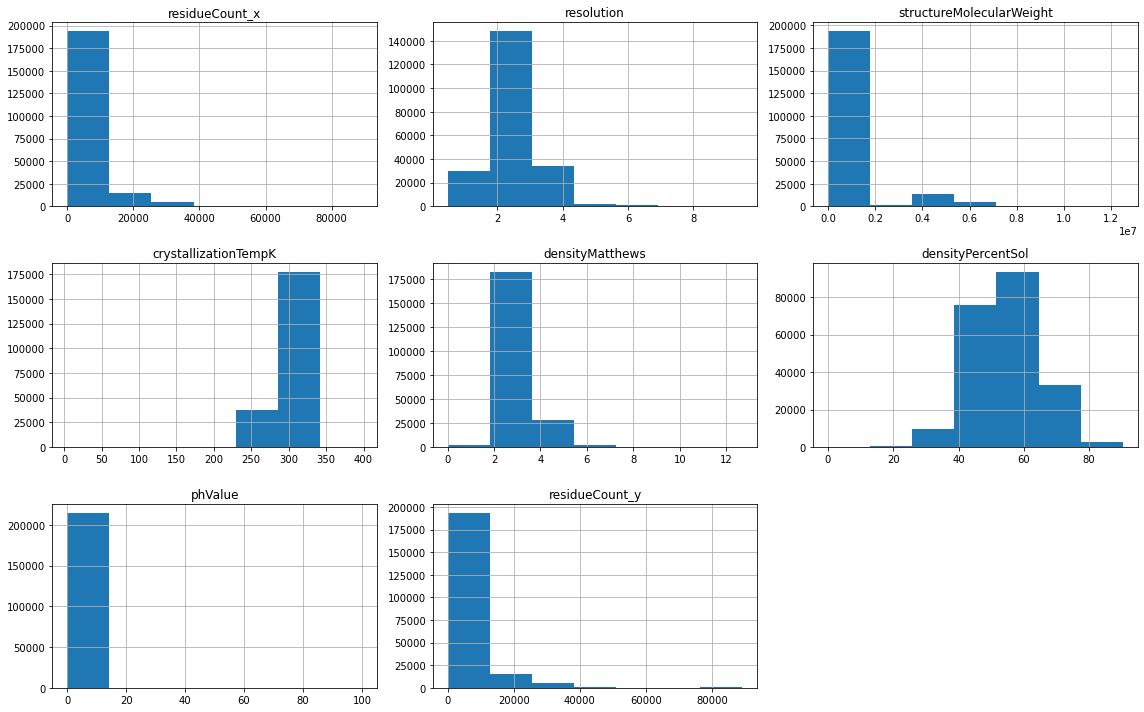

In [69]:
data_clean.hist(bins=7, figsize=(16, 10))
plt.tight_layout()

<AxesSubplot:xlabel='phValue', ylabel='count'>

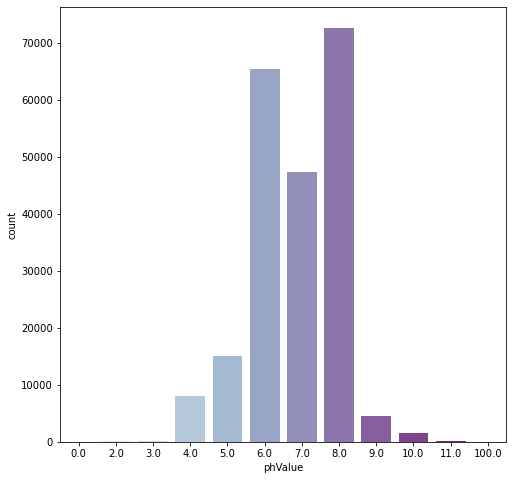

In [70]:
# Explorando os valores de pH para entender melhor a distribuição

plt.figure(figsize=(8,8))
sns.countplot(data=data_clean, x=data_clean['phValue'].round(), palette='BuPu')

<AxesSubplot:>

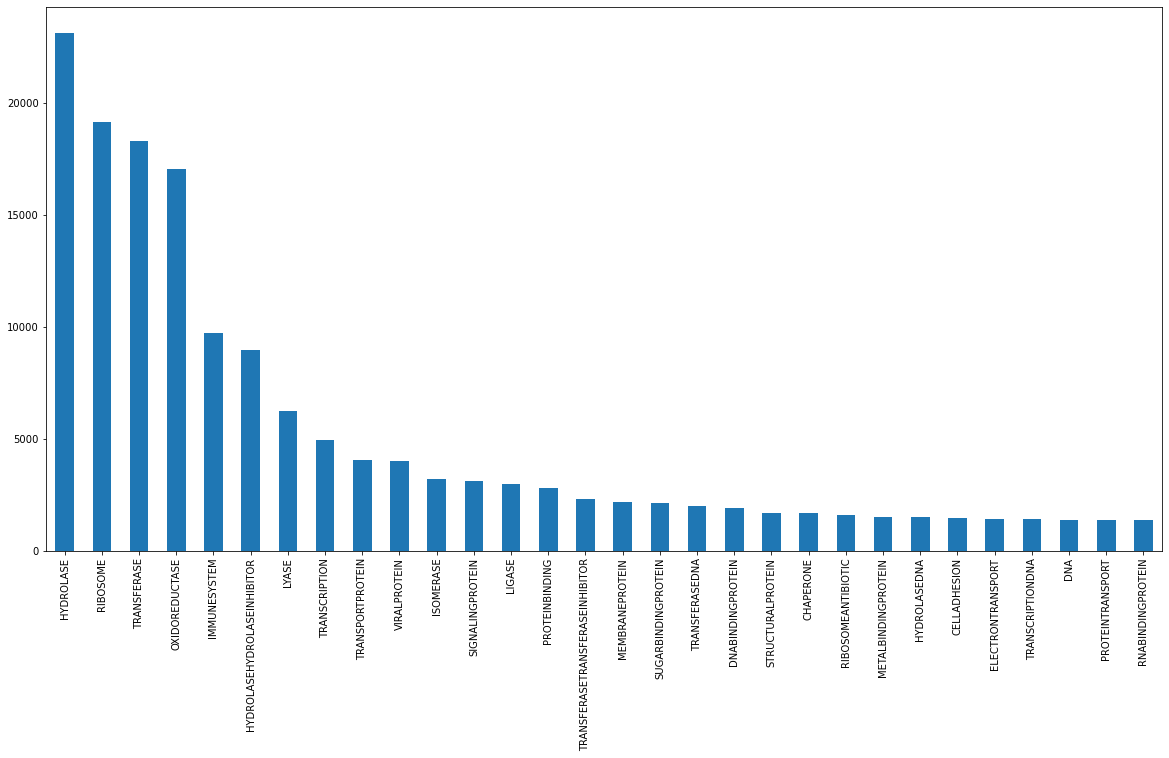

In [71]:
# Contagem de valores da variável target
# Filtrando as 30 classificações que mais aparecem no dataset


plt.figure(figsize=(20,10))
data_clean['classification'].value_counts()[:30].plot(kind='bar')

<AxesSubplot:>

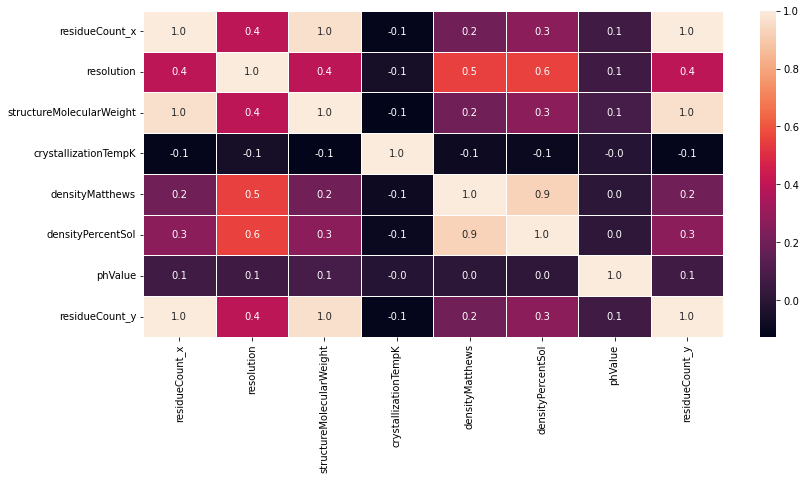

In [72]:
matriz_correl = data_clean.corr()
plt.figure(figsize=(13,6))
sns.heatmap(matriz_correl, annot=True, linewidths=.5, fmt= '.1f')

# 04. Preparando o dataframe usado para o modelo

In [73]:
# Variáveis com alta correlação entre elas: residueCount_y, residueCount_x, desntiyMatthews, densityPercentSol

data_new = data_clean.drop(columns = ['residueCount_y', 'residueCount_x', 'densityMatthews', 'densityPercentSol'])

In [74]:
data_new.info()

<class 'pandas.core.frame.DataFrame'>
Index: 215142 entries, 102D to 7BNA
Data columns (total 8 columns):
 #   Column                    Non-Null Count   Dtype  
---  ------                    --------------   -----  
 0   classification            215142 non-null  object 
 1   experimentalTechnique     215142 non-null  object 
 2   resolution                215142 non-null  float64
 3   structureMolecularWeight  215142 non-null  float64
 4   crystallizationMethod     215142 non-null  object 
 5   crystallizationTempK      215142 non-null  float64
 6   phValue                   215142 non-null  float64
 7   sequence                  215142 non-null  object 
dtypes: float64(4), object(4)
memory usage: 22.8+ MB


In [75]:
print("Quantidade de valores únicos para Classificação:", data_new['classification'].unique().shape[0])
print("Quantidade de valores únicos para Técnica experimental:", data_new['experimentalTechnique'].unique().shape[0])
print("Quantidade de valores únicos para Método de cristalização:", data_new['crystallizationMethod'].unique().shape[0])
print("Quantidade de valores únicos para Sequência:", data_new['sequence'].unique().shape[0])

Quantidade de valores únicos para Classificação: 2231
Quantidade de valores únicos para Técnica experimental: 9
Quantidade de valores únicos para Método de cristalização: 406
Quantidade de valores únicos para Sequência: 49952


In [76]:
# Retirar sequência e método de cristalização do modelo, para reduzir processamento

data_model = data_new.drop(columns=['crystallizationMethod', 'sequence'])

In [77]:
# Transformando os valores textuais de experimentalTechnique valores numéricos

data_model['experimentalTechnique'].unique()

array(['XRAYDIFFRACTION', 'POWDERDIFFRACTION', 'ELECTRONCRYSTALLOGRAPHY',
       'NEUTRONDIFFRACTION', 'XRAYDIFFRACTIONEPR', 'EPRXRAYDIFFRACTION',
       'NEUTRONDIFFRACTIONXRAYDIFFRACTION',
       'XRAYDIFFRACTIONNEUTRONDIFFRACTION',
       'SOLUTIONSCATTERINGXRAYDIFFRACTION'], dtype=object)

In [78]:
metodo_experimental = {
    'XRAYDIFFRACTION': 0,
    'POWDERDIFFRACTION': 1, 
    'ELECTRONCRYSTALLOGRAPHY': 2,
    'NEUTRONDIFFRACTION': 3, 
    'XRAYDIFFRACTIONEPR': 4, 
    'EPRXRAYDIFFRACTION': 5,
    'NEUTRONDIFFRACTIONXRAYDIFFRACTION': 6,
    'XRAYDIFFRACTIONNEUTRONDIFFRACTION': 7,
    'SOLUTIONSCATTERINGXRAYDIFFRACTION': 8
}

data_model['experimentalTechnique'] = data_model['experimentalTechnique'].map(metodo_experimental)
data_model.head()

,classification,experimentalTechnique,resolution,structureMolecularWeight,crystallizationTempK,phValue
structureId,,,,,,
102D,DNA,0,2.20,7637.17,277.0,7.0
102D,DNA,0,2.20,7637.17,277.0,7.0
110D,DNA,0,1.90,2337.73,277.0,6.6
111D,DNA,0,2.25,7374.83,277.0,6.6
111D,DNA,0,2.25,7374.83,277.0,6.6


In [84]:
# Por serem 2231 tipos distintos de classificações, aqui serão tratados apenas as 5 classificações mais frequentes

data_clean['classification'].value_counts()[:5]

HYDROLASE         23115
RIBOSOME          19120
TRANSFERASE       18270
OXIDOREDUCTASE    17037
IMMUNESYSTEM       9712
Name: classification, dtype: int64

In [86]:
# Filtrando o dataset para ter só as 5 classificações acima

data_final = data_model.query("classification == ['HYDROLASE', 'RIBOSOME', 'TRANSFERASE', 'OXIDOREDUCTASE', 'IMMUNESYSTEM']")
data_final.info()

<class 'pandas.core.frame.DataFrame'>
Index: 87254 entries, 1A72 to 6F6P
Data columns (total 6 columns):
 #   Column                    Non-Null Count  Dtype  
---  ------                    --------------  -----  
 0   classification            87254 non-null  object 
 1   experimentalTechnique     87254 non-null  int64  
 2   resolution                87254 non-null  float64
 3   structureMolecularWeight  87254 non-null  float64
 4   crystallizationTempK      87254 non-null  float64
 5   phValue                   87254 non-null  float64
dtypes: float64(4), int64(1), object(1)
memory usage: 4.7+ MB


In [87]:
data_final.head()

,classification,experimentalTechnique,resolution,structureMolecularWeight,crystallizationTempK,phValue
structureId,,,,,,
1A72,OXIDOREDUCTASE,0,2.6,40658.50,277.0,8.40
1AR4,OXIDOREDUCTASE,0,1.9,45428.53,277.0,6.10
1AR4,OXIDOREDUCTASE,0,1.9,45428.53,277.0,6.10
1AR5,OXIDOREDUCTASE,0,1.6,45430.34,277.0,6.15
1AR5,OXIDOREDUCTASE,0,1.6,45430.34,277.0,6.15


In [89]:
print("Total de observações no dataframe final:", data_final.shape[0])
print("Total de observações no dataframe inicial:", data.shape[0])

Total de observações no dataframe final: 87254
Total de observações no dataframe inicial: 471149


# 05. Visualizando a variável target (classificação das proteinas)

<AxesSubplot:title={'center':'Distribuição da variável Reslution'}, xlabel='classification', ylabel='resolution'>

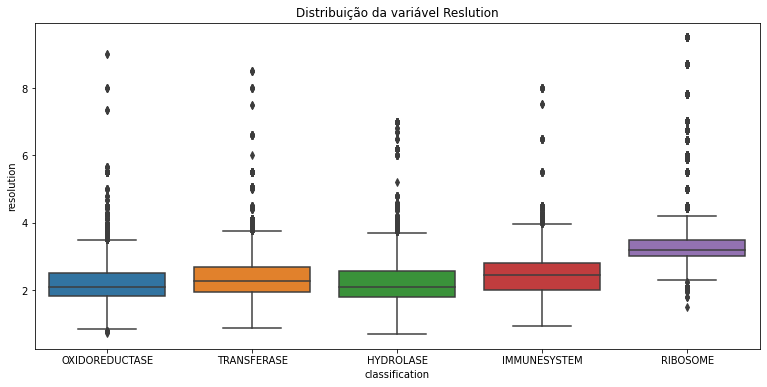

In [99]:
plt.figure(figsize=(13,6))
plt.title('Distribuição da variável Reslution')
sns.boxplot(x=data_final['classification'], y=data_final['resolution'], orient='v')

<AxesSubplot:title={'center':'Distribuição do Peso da estrutura molecular'}, xlabel='classification', ylabel='structureMolecularWeight'>

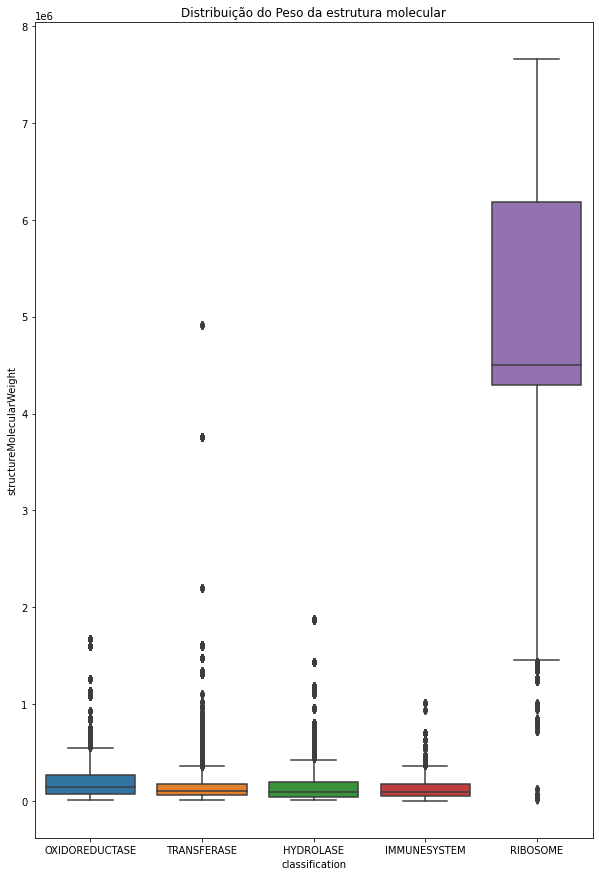

In [106]:
plt.figure(figsize=(10,15))
plt.title('Distribuição do Peso da estrutura molecular')
sns.boxplot(x=data_final['classification'], y=data_final['structureMolecularWeight'], orient='v')

<AxesSubplot:title={'center':'Distribuição da temperatura de cristalização (em K)'}, xlabel='classification', ylabel='crystallizationTempK'>

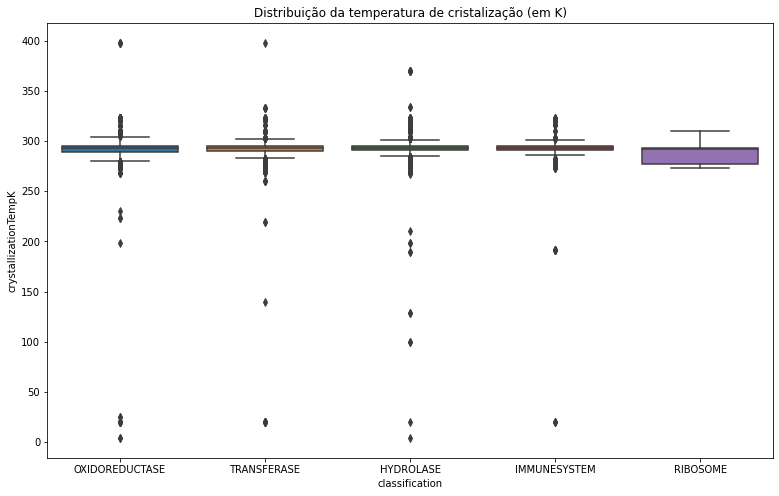

In [109]:
plt.figure(figsize=(13,8))
plt.title('Distribuição da temperatura de cristalização (em K)')
sns.boxplot(x=data_final['classification'], y=data_final['crystallizationTempK'], orient='v')

<AxesSubplot:title={'center':'Distribuição do valor de pH'}, xlabel='classification', ylabel='phValue'>

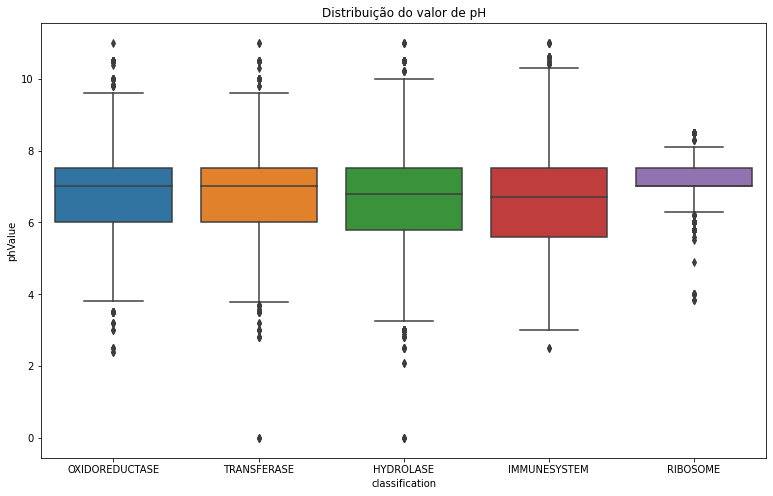

In [110]:
plt.figure(figsize=(13,8))
plt.title('Distribuição do valor de pH')
sns.boxplot(x=data_final['classification'], y=data_final['phValue'], orient='v')

# 06. Preparando o dataframe para treino e teste

In [111]:
# Transformando as classificações em valores numéricos
data_final['classification'].unique()

array(['OXIDOREDUCTASE', 'TRANSFERASE', 'HYDROLASE', 'IMMUNESYSTEM',
       'RIBOSOME'], dtype=object)

In [113]:
clases = {
    'OXIDOREDUCTASE':0, 
    'TRANSFERASE':1, 
    'HYDROLASE':2, 
    'IMMUNESYSTEM':3,
    'RIBOSOME':4
}

In [114]:
data_final['classification'] = data_final['classification'].map(clases)
data_final.head()

C:\Users\gusta\AppData\Local\Temp/ipykernel_14148/1368654941.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data_final['classification'] = data_final['classification'].map(clases)


,classification,experimentalTechnique,resolution,structureMolecularWeight,crystallizationTempK,phValue
structureId,,,,,,
1A72,0,0,2.6,40658.50,277.0,8.40
1AR4,0,0,1.9,45428.53,277.0,6.10
1AR4,0,0,1.9,45428.53,277.0,6.10
1AR5,0,0,1.6,45430.34,277.0,6.15
1AR5,0,0,1.6,45430.34,277.0,6.15


In [115]:
# Processando as variáveis explicativas para facilitar a padronização

from sklearn import preprocessing
from sklearn.preprocessing import MinMaxScaler

In [119]:
min_max_scaler = preprocessing.MinMaxScaler()

y = data_final['classification']
x = data_final.drop(columns=['classification'])

X_transformado = min_max_scaler.fit_transform(x)

print(y)
print(X_transformado)

structureId
1A72    0
1AR4    0
1AR4    0
1AR5    0
1AR5    0
       ..
6F1H    2
6F6P    2
6F6P    2
6F6P    2
6F6P    2
Name: classification, Length: 87254, dtype: int64
[[0.         0.21590909 0.00503314 0.6928934  0.76363636]
 [0.         0.13636364 0.00565641 0.6928934  0.55454545]
 [0.         0.13636364 0.00565641 0.6928934  0.55454545]
 ...
 [0.         0.19886364 0.00599175 0.7284264  0.66363636]
 [0.         0.19886364 0.00599175 0.7284264  0.66363636]
 [0.         0.19886364 0.00599175 0.7284264  0.66363636]]


In [120]:
# Separando base de treino e teste

from sklearn.model_selection import train_test_split

In [121]:
SEED = 1337
X_train, X_test, y_train, y_test = train_test_split(X_transformado, y, test_size=0.3, random_state=SEED)

print("Quantidade de observações para treino:", X_train.shape[0])
print("Quantidade de observações para teste:", X_test.shape[0])

Quantidade de observações para treino: 61077
Quantidade de observações para teste: 26177


# 07. Treinando e avaliando os primeiros modelos de classificação

In [129]:
from sklearn.dummy import DummyClassifier
from sklearn.svm import SVC
from sklearn.neighbors import KNeighborsClassifier
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import confusion_matrix

In [127]:
# Definindo a função que será usada para os treinos e teste de acurácia

def treinar_modelo(metodo, X_treino, X_teste, y_treino, y_teste):
    modelo = metodo()
    modelo_treinado = modelo.fit(X_treino, y_treino)
    matriz_confusao = confusion_matrix(y_teste,modelo_treinado.predict(X_teste))
    plt.figure(figsize = (10, 8))
    sns.set(font_scale= 2)
    sns.heatmap(matriz_confusao, annot = True, fmt = "d").set(xlabel = "Predição", ylabel= "Real")
    print("Resultado de acurácia da classificação: %.2f%%" %(modelo_treinado.score(X_teste,y_teste)*100))

Resultado de acurácia da classificação: 26.00%


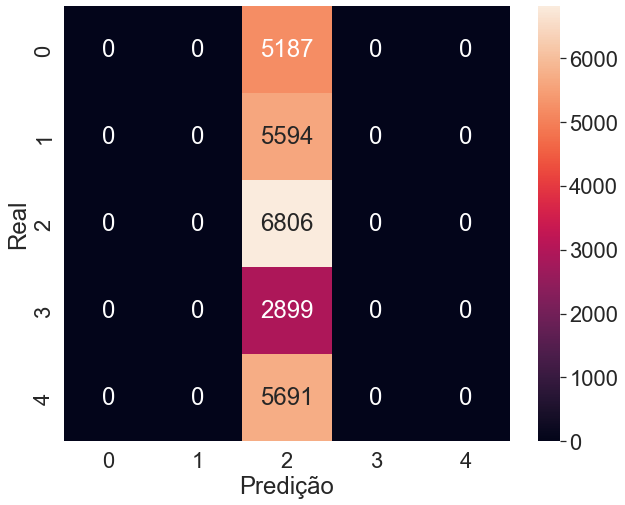

In [130]:
treinar_modelo(DummyClassifier,X_train, X_test, y_train, y_test)

Resultado de acurácia da classificação: 47.42%


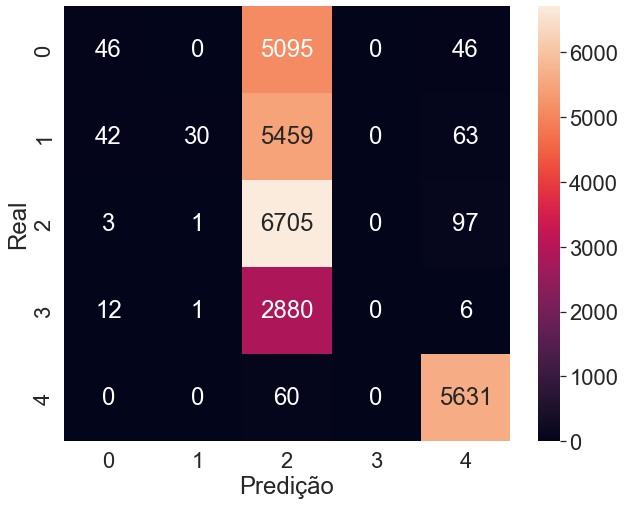

In [128]:
treinar_modelo(SVC, X_train, X_test, y_train, y_test)

Resultado de acurácia da classificação: 75.51%


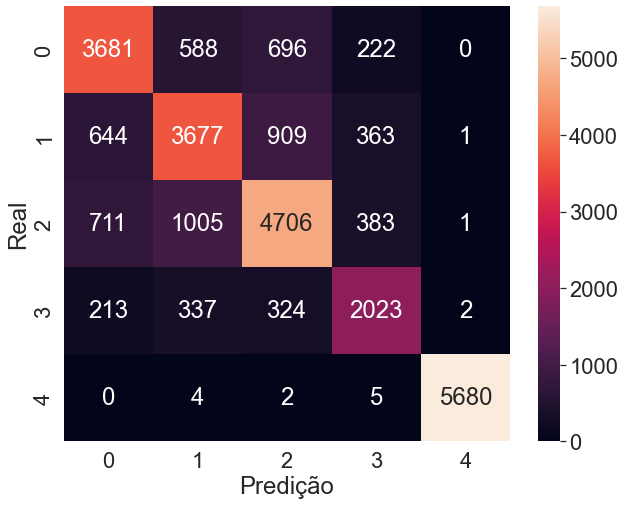

In [131]:
treinar_modelo(KNeighborsClassifier,X_train, X_test, y_train, y_test)

Resultado de acurácia da classificação: 91.27%


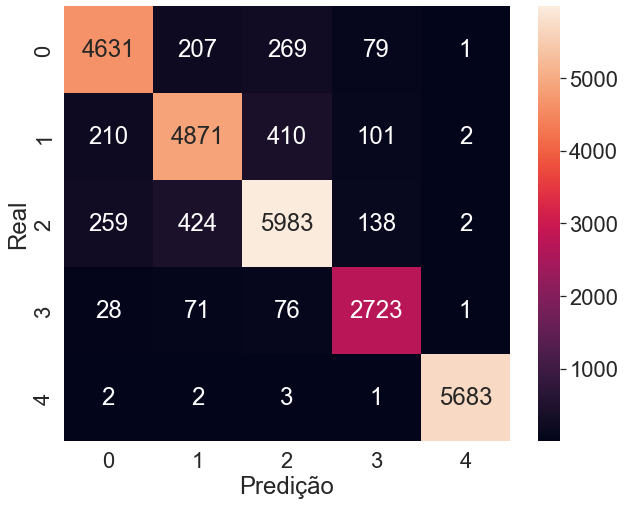

In [132]:
treinar_modelo(DecisionTreeClassifier,X_train, X_test, y_train, y_test)

Resultado de acurácia da classificação: 92.21%


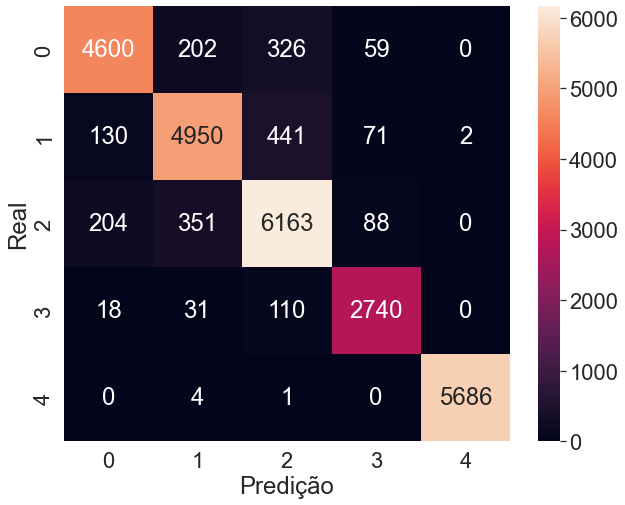

In [133]:
treinar_modelo(RandomForestClassifier,X_train, X_test, y_train, y_test)

Modelo campeão da primeira rodada de treino: Random Forest Classifier